# Conformal prediction for Classifiers

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from math import ceil
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import Lambda, ToTensor

### Train and test datasets

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
print(len(training_data))
print(len(test_data))

60000
10000


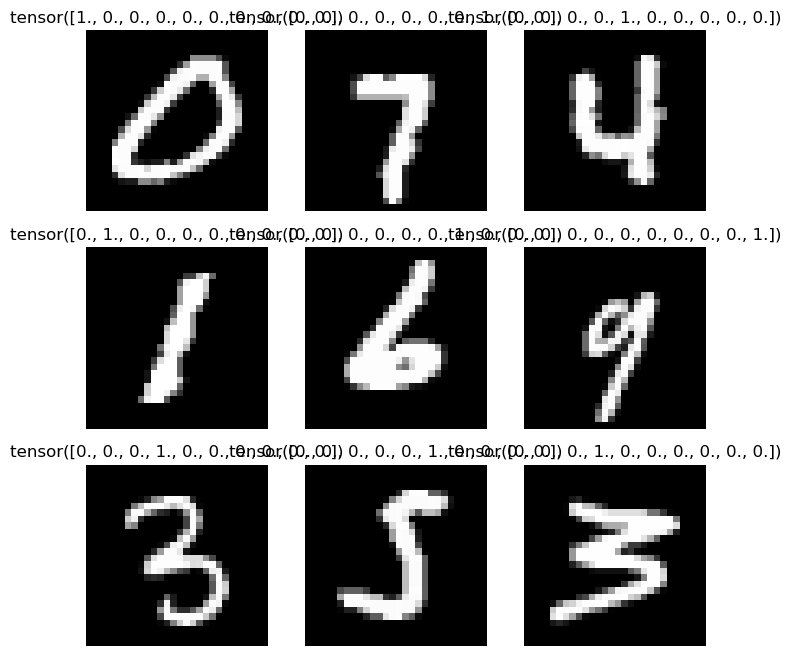

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Batch definition

In [5]:
batch_size = 64

In [6]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64, 10])


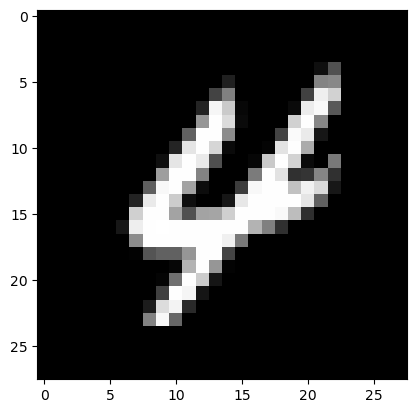

Label: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


In [7]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Multilayer perceptron (Number Network)
### Definition

In [8]:
class NumberNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NumberNetwork()

In [9]:
model

NumberNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)

### Hyperparameters, loss function and optimizer

In [10]:
learning_rate = 1e-1
epochs = 5

In [11]:
loss_fn = nn.CrossEntropyLoss()

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Train and test code definition

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

def show_img_class(img, y):
    plt.imshow(img.squeeze(), cmap="gray")
    plt.show()
    print(y)

### Training

In [14]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302722  [   64/60000]
loss: 2.297389  [ 6464/60000]
loss: 2.288305  [12864/60000]
loss: 2.243886  [19264/60000]
loss: 2.059743  [25664/60000]
loss: 1.815738  [32064/60000]
loss: 1.732621  [38464/60000]
loss: 1.765031  [44864/60000]
loss: 1.740663  [51264/60000]
loss: 1.675658  [57664/60000]
Test Error: 
 Accuracy: 82.3%, Avg loss: 1.666153 

Epoch 2
-------------------------------
loss: 1.633364  [   64/60000]
loss: 1.612669  [ 6464/60000]
loss: 1.717166  [12864/60000]
loss: 1.701394  [19264/60000]
loss: 1.653780  [25664/60000]
loss: 1.633486  [32064/60000]
loss: 1.652363  [38464/60000]
loss: 1.678439  [44864/60000]
loss: 1.662823  [51264/60000]
loss: 1.660618  [57664/60000]
Test Error: 
 Accuracy: 84.4%, Avg loss: 1.623985 

Epoch 3
-------------------------------
loss: 1.599136  [   64/60000]
loss: 1.577898  [ 6464/60000]
loss: 1.578751  [12864/60000]
loss: 1.587915  [19264/60000]
loss: 1.602502  [25664/60000]
loss: 1.572089  [32064/600

### Example

In [15]:
img, y = test_data[0]

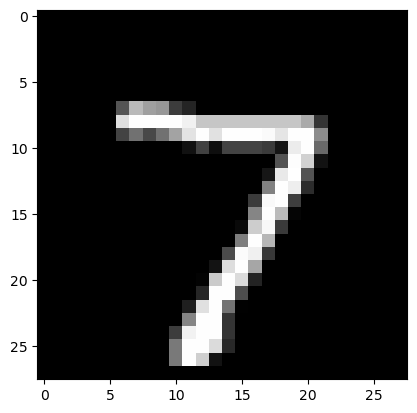

7


In [16]:
show_img_class(img, y)

In [17]:
model.eval()
with torch.no_grad():
    output = model(img)
print(output)

tensor([[6.3714e-09, 3.3048e-15, 2.5393e-08, 2.3340e-06, 1.1671e-14, 2.5125e-08,
         1.8997e-17, 1.0000e+00, 9.0462e-10, 2.5467e-07]])


In [18]:
output.sum().item()

1.0

### not_so_sure

In [19]:
not_so_sure = []
model.eval()
with torch.no_grad():
    for elem in test_data:
        output = model(elem[0])
        if output[0].max().item() < 0.6:
            not_so_sure.append(elem)

In [20]:
len(not_so_sure)

224

In [21]:
img, y = not_so_sure[1]
model.eval()
with torch.no_grad():
    output = model(img)
print(output)

tensor([[6.2505e-07, 1.2700e-07, 3.4034e-06, 1.6699e-06, 4.8221e-01, 3.8859e-03,
         3.0604e-05, 1.6562e-04, 1.1551e-02, 5.0215e-01]])


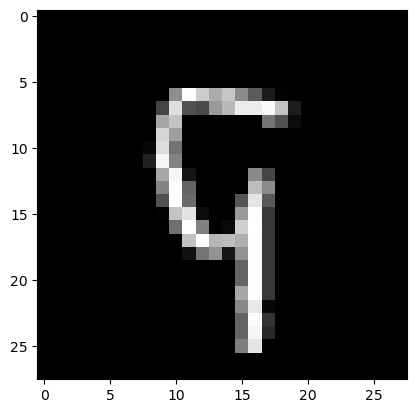

9


In [22]:
show_img_class(img, y)

## Conformal prediction and uncertainty quantification

In [23]:
len(test_data)

10000

In [24]:
num_samples = 100

In [25]:
alpha = 0.1

In [26]:
conformal_dataset = Subset(test_data, torch.arange(num_samples))

### Old method

In [27]:
list_scores = []
model.eval()
with torch.no_grad():
    for img, y in conformal_dataset:
        correct_class_score = model(img).flatten()[y]
        list_scores.append(correct_class_score)

In [28]:
# alpha_hat = ?

In [29]:
q = np.quantile(list_scores, alpha, method='lower')
print(q)

0.9760617


### New method

In [30]:
list_sum_scores = []
model.eval()
with torch.no_grad():
    for img, y in conformal_dataset:
        scores = list(enumerate(model(img).flatten()))
        scores_until_correct = [score for num, score in scores if score >= scores[y][1]]  # or num == y
        list_sum_scores.append(sum(scores_until_correct))

In [31]:
p = 1-alpha
print(p)

0.9


In [32]:
p_hat = ceil((num_samples+1)*p) / num_samples
print(p_hat)

0.91


In [33]:
q_hat = np.quantile(list_sum_scores, p_hat, method='higher')
print(q_hat)

0.99999976


### Getting prediction sets

In [34]:
def get_prediction_list(img):
    prediction_list = []
    sorted_scores = sorted(enumerate(model(img).flatten()), key=lambda item: item[1], reverse=True)
    cumsum = 0
    for num, score in sorted_scores:
        cumsum += score
        prediction_list.append(num)
        if cumsum >= q_hat:
            break
    return prediction_list

In [35]:
def run_predictions_data(data):
    df = pd.DataFrame(columns=['true_class', 'prediction_list'])
    model.eval()
    with torch.no_grad():
        for idx, (img, y) in enumerate(data):
            df.loc[len(df)] = {'true_class': y, 'prediction_list': get_prediction_list(img)}
    return df

In [36]:
remaining_test_data = Subset(test_data, torch.arange(num_samples, len(test_data)))
print(len(remaining_test_data))

9900


In [37]:
results = run_predictions_data(remaining_test_data)
display(results)

,true_class,prediction_list
0,6,"[6, 2, 8, 4, 5]"
1,0,"[0, 5]"
2,5,"[5, 8]"
3,4,[4]
4,9,"[9, 4, 5, 8, 3, 0, 7, 2]"
...,...,...
9895,2,"[2, 3]"
9896,3,[3]
9897,4,"[4, 9, 8]"
9898,5,"[5, 8, 4, 6, 1, 0]"


### Some data

Let's see the average list size for correctly predicted classes vs incorrect ones.

**No hi ha classes correctes i incorrectes com a tal, però entenc que no té sentit retornar el conjunt sense ordre...**

In [38]:
sizes_correct = {length: 0 for length in range(1, 11)}
sizes_incorrect = {length: 0 for length in range(1, 11)}

def calculate_sizes(row):
    if row['true_class'] == row['prediction_list'][0]:
        sizes_correct[len(row['prediction_list'])] += 1
    else:
        sizes_incorrect[len(row['prediction_list'])] += 1

model.eval()
with torch.no_grad():
    results.apply(calculate_sizes, axis=1)

In [39]:
def compute_avg_size(sizes):
    total = sum(sizes.values())
    relative = {length: size/total for length, size in sizes.items()}
    avg_size = sum(length*percent for length, percent in relative.items())
    return avg_size

In [40]:
print(compute_avg_size(sizes_correct))
print(compute_avg_size(sizes_incorrect))

3.6640311924618216
6.09295352323838
